# Проект: Рекомендация тарифов

### Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* сalls — количество звонков
* minutes — суммарная длительность звонков в минутах
* messages — количество sms-сообщений
* mb_used — израсходованный интернет-трафик в Мб
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import tqdm

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from matplotlib.legend import Legend

from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier

set_matplotlib_formats('retina')

## Знакомство с данными 

Читаем данные

In [3]:
try: 
    data = pd.read_csv('/datasets/users_behavior.csv')
except FileNotFoundError:
    data = pd.read_csv('users_behavior.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data.duplicated().sum()

0

Пропустков или дубликатов в данных нет. Целевая переменная тут `is_ultra`. Разделим данные и посмотрим как связаны между собой признаки

In [6]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

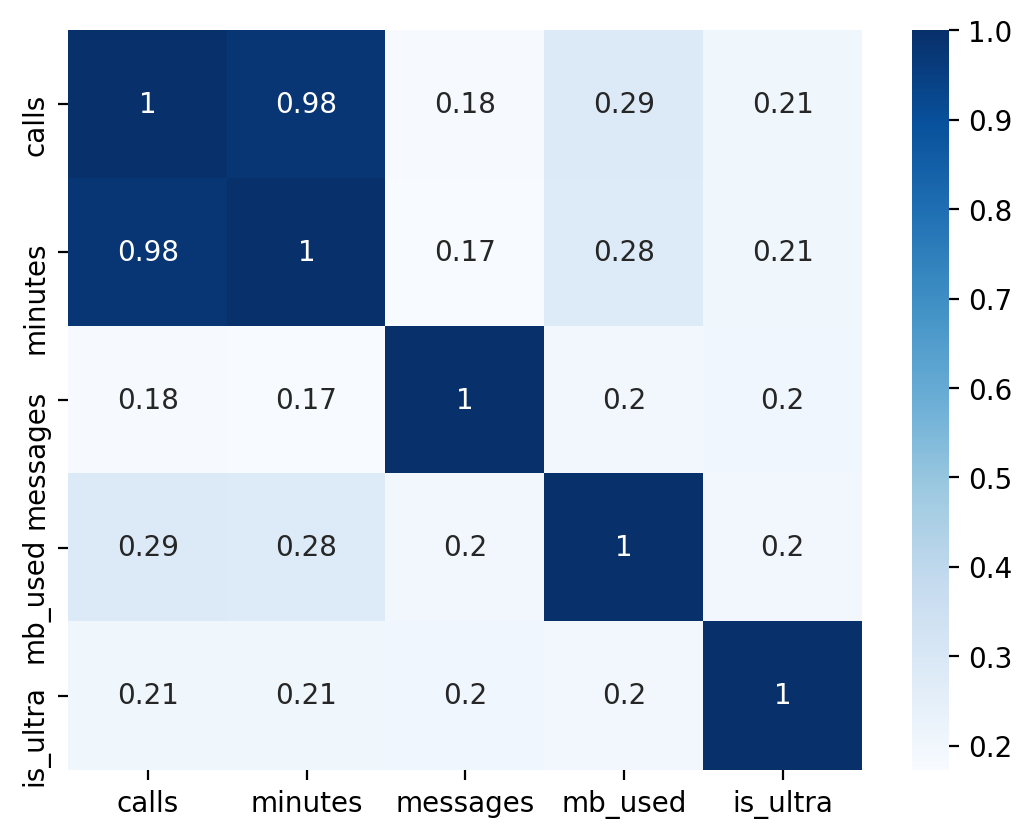

In [7]:
sns.heatmap(data.corr(), cmap=plt.cm.Blues, annot=True);

`calls` и `minutes` сильно коррелируют между собой. Значит, один признак можно хорошо восстановить по-другому, то есть они почти линейнозависимые и держать оба признака особо смысла нет. Разница только в том, что первый признак - дискретный, а второй непрерывный. Оставим непрерывный

In [8]:
features = features.drop('calls', axis=1)

In [9]:
features.head()

,minutes,messages,mb_used
0,311.90,83.0,19915.42
1,516.75,56.0,22696.96
2,467.66,86.0,21060.45
3,745.53,81.0,8437.39
4,418.74,1.0,14502.75


In [10]:
list_combinations = list(combinations(features.columns, 2))

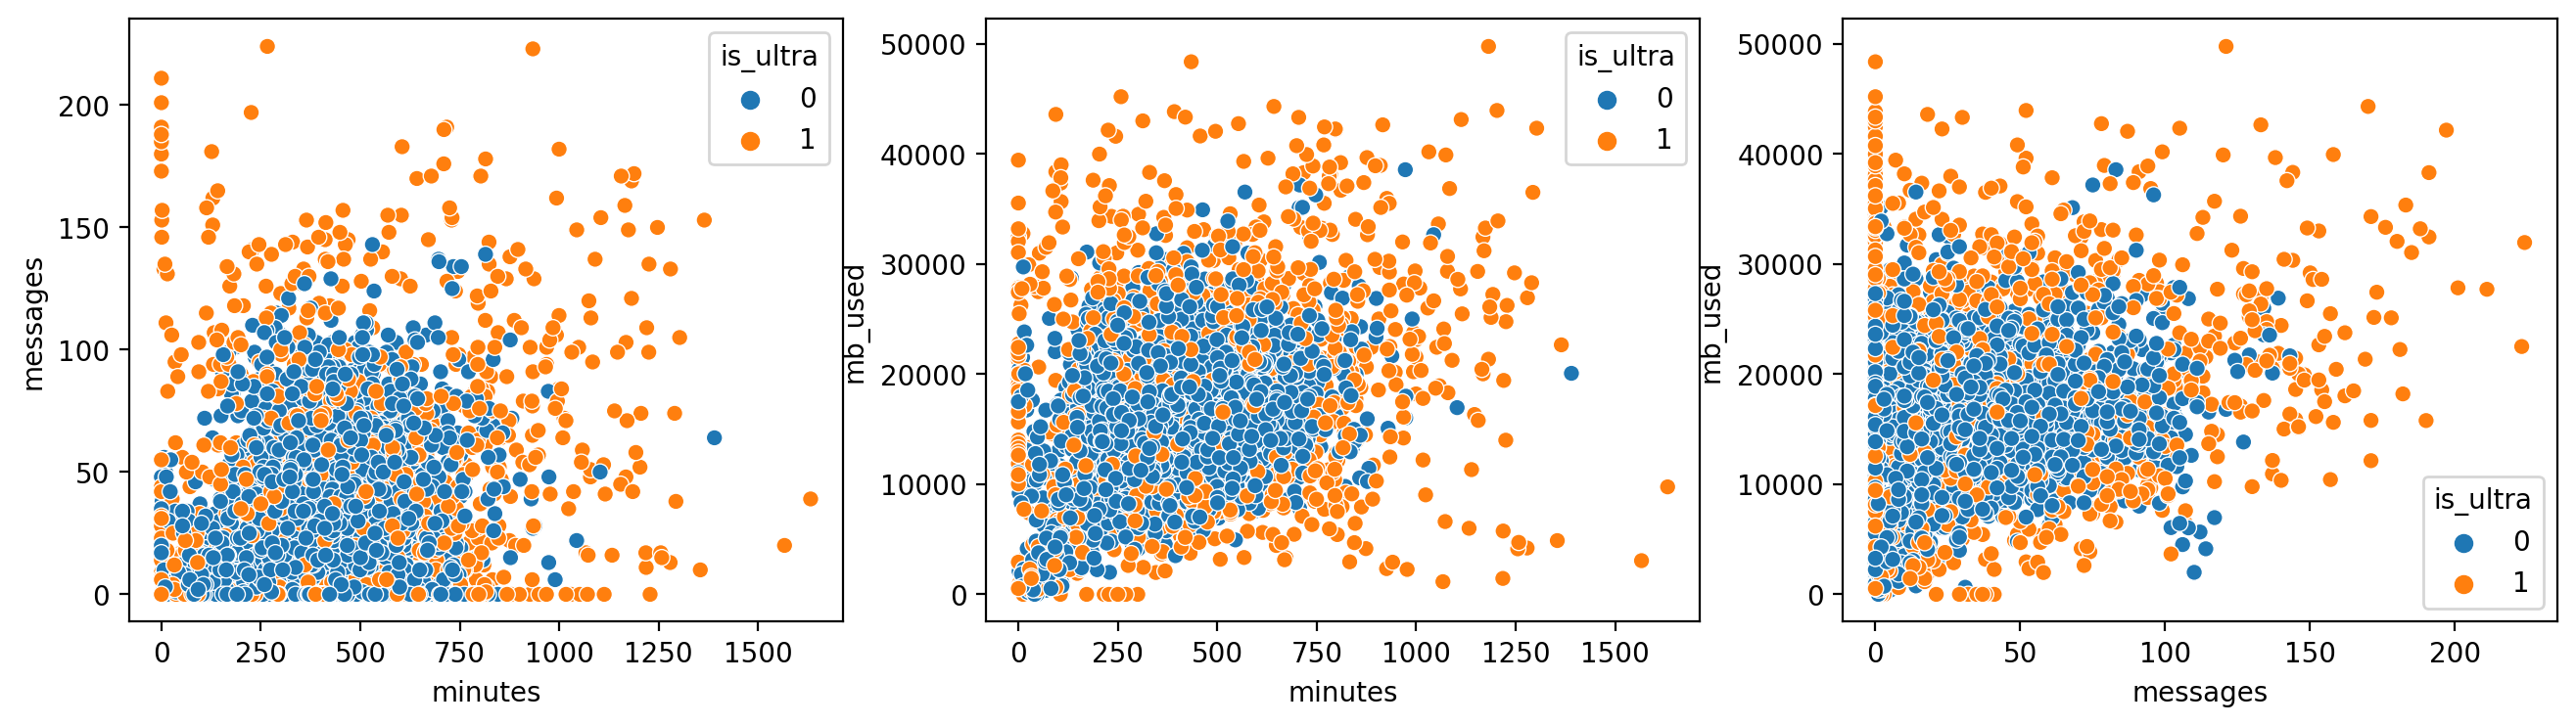

In [11]:
fig, ax = plt.subplots(1, len(list_combinations), figsize=(16, 4))
for num, axis in enumerate(ax):
    x, y = list_combinations[num]
    sns.scatterplot(
        ax=axis,
        x=features[x], 
        y=features[y], 
        hue=target
    )

По оставшимся признакам видно, что пользователи тарифа "Смарт" представляют собой условно центры зависимостей, а остальные пользователи разбросаны как-бы вокруг них. Другими словами большинство пользователей тарифов "Ультра" в распределениях будут иметь значения по одному или нескольким параметрам около зоны выбросов или непостредственно в ней. 

Также видно, что некоторые пользователи, имея тариф "Ультра", не используют его возможности - это оранжевые точки около начала координат. И есть обратные ситуации - синие точки на окраинах, то есть эти пользователи превышают лимиты по своему тарифу. Следовательно, можно им было бы предложить сменить тариф.

Также сразу видно, что линейной зависимотью такие данные не разделить.

Еще можно отнормировать признаки, чтобы Логистической регресси было попроще сходиться (на деревья это не должно повлиять)

Также оценим есть ли дибаланс в наших данных

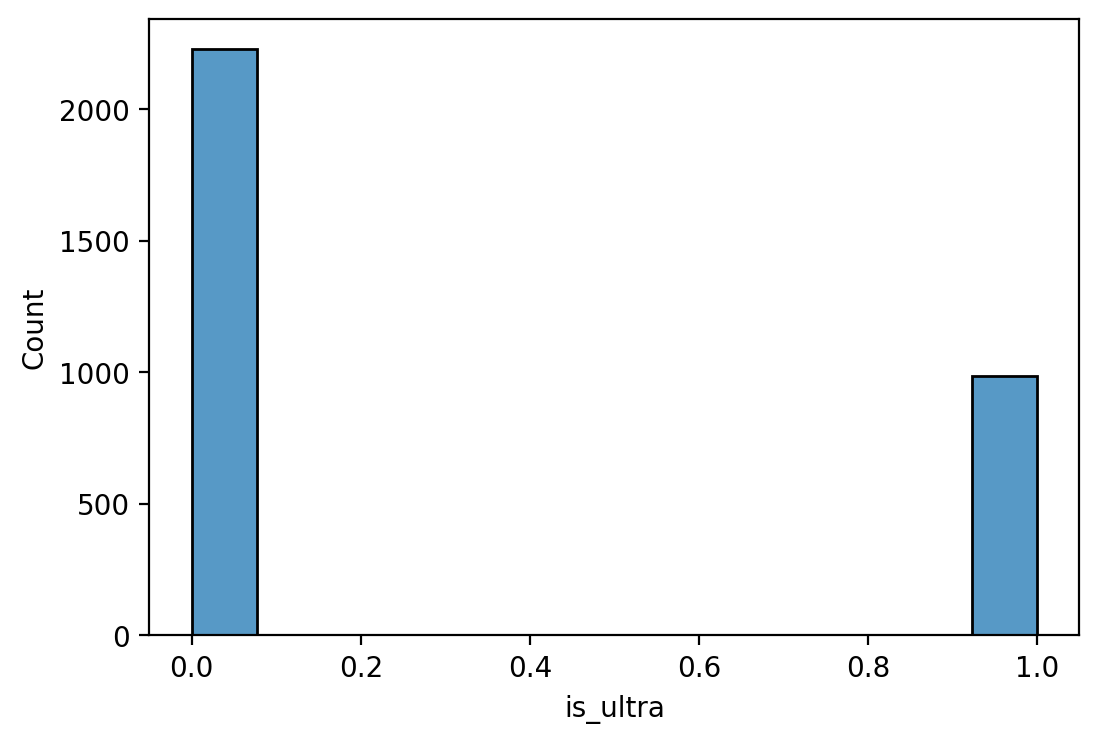

In [13]:
plt.figure(figsize=(6,4))
sns.histplot(data=target);

Получается, что у нас классы распределены как два к одному. Дибаланс классов может быть и свойством данных. На данный момент это не особо ясно, поэтому пока просто будем иметь его ввиду, что он у нас есть и учтем это в построении моделей, если понадобится

## Разбейте данные на выборки

Здесь я добавил еще параметр `stratify`, чтобы в наших выборках было примерно одинаковое соотношение между двумя предсказываемыми тарифами. То есть я хочу избежать ситуации, когда бы мы обучались только на тарифе "Смарт", а предсказывали для тарифа "Ультра"

In [14]:
# Зафиксируем генератор случайных чисел для воспроизводимости результатов
seed = 44

In [15]:
tv_features, test_features, tv_target, test_target = train_test_split(features, target, 
                                                                      random_state=seed, 
                                                                      test_size=0.25, 
                                                                      stratify=target
                                                                     )

In [16]:
train_features, valid_features, train_target, valid_target = train_test_split(tv_features, tv_target, 
                                                                              random_state=seed, 
                                                                              test_size=0.2,
                                                                              stratify=tv_target
                                                                     )

Тут не совсем понимаю, какие пропорции лучше выбрать, потому что видимо данных маловато и выходит так, что становится важно сколько я отдаю данных на тренировочную, валидационную и тестовую выборки. Получается, что результат скачет примерно на 1-2%, когда я меняю соотношения для тестовой и валидационной выборкок на 0.05

Хочется отдать как можно больше данных для обучения модели, но тогда ее промахи будут стоит дороже для точности. Условно, 1 из 10 и 1 из 20 - это большая разница. Сейчас я "нащупал" такие соотношения. 

In [17]:
tv_target.shape, test_target.shape, test_target.shape[0] / tv_target.shape[0]

((2410,), (804,), 0.33360995850622405)

In [18]:
train_target.shape, valid_target.shape, valid_target.shape[0] / train_target.shape[0]

((1928,), (482,), 0.25)

Здесь отмасштабируем признаки


In [19]:
scaler = MinMaxScaler()
scaler.fit(train_features)

MinMaxScaler()

In [20]:
train_features = scaler.transform(train_features)
valid_features = scaler.transform(valid_features)
test_features = scaler.transform(test_features)

## Строим модели

В этом разделе мы поочередно исследуем три модели:
1. Логистическая регрессия
2. Решающее дерево
3. Случайный лес

Для каждой модели мы поперебираем гиперпараметры и выбирем лучшую на основе показаний на валидационном датасете

### LogisticRegression

Для модели логистической регрессии мы варьируем коэффициент регуляризации

In [21]:
best_lr_result = 0
best_lr_model = None
lr_train_score = []
lr_valid_score = []

cs = np.arange(0.05, 2, 0.05)
for c in tqdm.tqdm(cs):
    lr_model = LogisticRegression(
        random_state=seed,
        solver='lbfgs',
        max_iter=2000,
        C=c,
    )

    lr_model.fit(train_features, train_target)
    current_result = accuracy_score(valid_target, lr_model.predict(valid_features))
    
    lr_train_score.append(accuracy_score(train_target, lr_model.predict(train_features)))
    lr_valid_score.append(current_result)
    
    if current_result > best_lr_result:
        best_lr_result = current_result
        best_lr_model = lr_model

100%|██████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 74.59it/s]


Добавим график зависимости точности модели на тренировочной и валидационной выборках. 
Фиолетовой точкой отмечена лучшая модель по точности на валидационной выборке


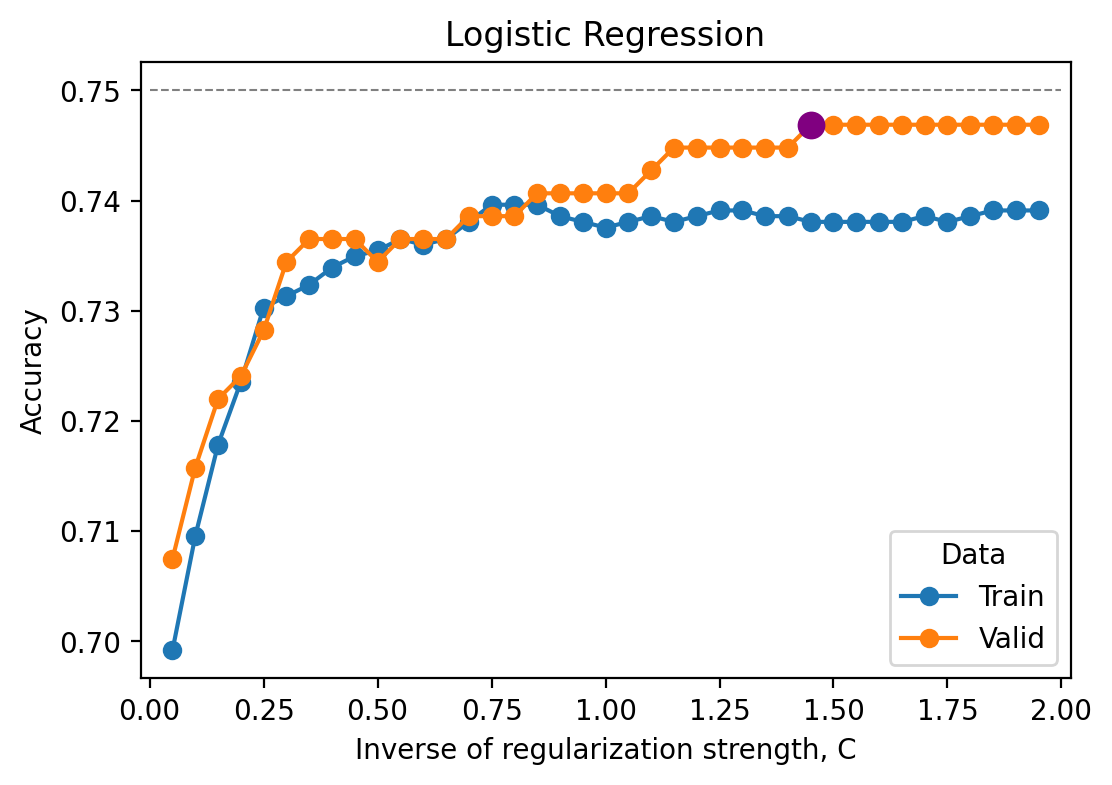

In [22]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cs, lr_train_score, marker='o', zorder=0)
ax.plot(cs, lr_valid_score, marker='o', zorder=0)
ax.scatter(best_lr_model.C, best_lr_result, c='purple', s=81, zorder=1)
ax.hlines(0.75, 0, 2, lw=0.75, ls='--', color='gray')
ax.set_title("Logistic Regression")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Inverse of regularization strength, C")
ax.set_xlim(-0.02, 2.02)
ax.legend(['Train', "Valid"], title='Data', loc=4);

In [23]:
print(f"Best LR model: {best_lr_model}")

Best LR model: LogisticRegression(C=1.4500000000000002, max_iter=2000, random_state=44)


In [24]:
print(f"Validation Result: {best_lr_result}")

Validation Result: 0.7468879668049793


### DecisionTreeClassifier
В модели единичного дерева мы будет изменять глубину разбиения `max_depth` для двух подходов (`gini`, `entropy`) к измерению качества при разбиении нашего дерева 

In [25]:
max_depth = range(1, 20)
best_tree_result = 0
best_tree_model = None

tree_train_score = []
tree_valid_score = []

for depth in max_depth:
    for criterion in ['gini', 'entropy']:
        model = DecisionTreeClassifier(random_state=seed, max_depth=depth, criterion=criterion)
        model.fit(train_features, train_target)
        prediction_valid = model.predict(valid_features)

        current_result = accuracy_score(valid_target, prediction_valid)
        
        tree_train_score.append(accuracy_score(train_target, model.predict(train_features)))
        tree_valid_score.append(current_result)
        
        if current_result > best_tree_result:
            best_tree_result = current_result
            best_tree_model = model
    

Построим график изменения точности алгоритма от глубины дерева 

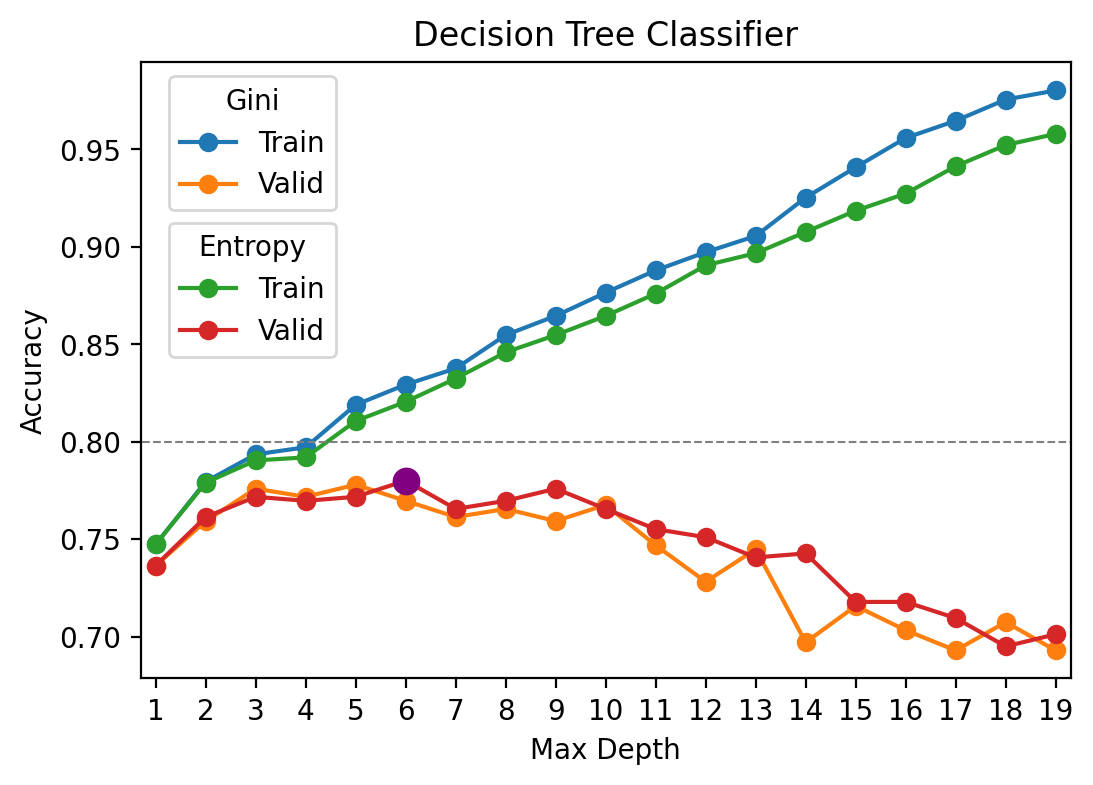

In [26]:
plots = []
fig, ax = plt.subplots(figsize=(6,4))
plots += ax.plot(max_depth, tree_train_score[::2], marker='o', zorder=0)
plots += ax.plot(max_depth, tree_valid_score[::2], marker='o', zorder=0)
plots += ax.plot(max_depth, tree_train_score[1::2], marker='o', zorder=0)
plots += ax.plot(max_depth, tree_valid_score[1::2], marker='o', zorder=0)
ax.scatter(best_tree_model.max_depth, best_tree_result, c='purple', s=81, zorder=1)
ax.hlines(0.8, 0.5, 19.5, lw=0.75, ls='--', color='gray')
ax.set_title("Decision Tree Classifier")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max Depth")
ax.set_xticks(max_depth)
ax.set_xticklabels(max_depth);
ax.set_xlim(0.7, 19.3)
ax.legend(plots[:2], ['Train', "Valid"], title='Gini', bbox_to_anchor=(0.225, 1));
leg = Legend(ax, plots[2:], ['Train', "Valid"], title='Entropy', bbox_to_anchor=(0.225, 0.5))
ax.add_artist(leg);

In [27]:
print(f"Validation Result: {best_tree_result:.3f}\nby model {best_tree_model}")

Validation Result: 0.780
by model DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=44)


Видно, что единичное дерево довольно легко переобучается. Уже начиная с глубины дерева равной 9 качество на валидационной выборке начинает сильно просаживаться.


### RandomForest
В модели случайного леса варьируем те же параметры как и для модели единичного дерева и дополнительно возьмем число деревьев `n_estimators`

In [28]:
%%time
forest_sizes = [2] + list(range(5, 21, 5)) + [25, 50]
max_depth = range(1, 20)

best_forest_result = 0
best_forest_model = None


for forest_size in tqdm.tqdm(forest_sizes, desc='N trees Loop'):
    for depth in max_depth:
        for criterion in ['gini', 'entropy']:
            model = RandomForestClassifier(
                criterion=criterion,
                n_estimators=forest_size,
                max_depth=depth,
                n_jobs=-1, 
                random_state=seed
            )
            model.fit(train_features, train_target)
            prediction_valid = model.predict(valid_features)

            current_result = accuracy_score(valid_target, prediction_valid)
            if current_result > best_forest_result:
                best_forest_result = current_result
                best_forest_model = model

N trees Loop: 100%|██████████████████████████████████████████████| 7/7 [00:20<00:00,  2.97s/it]

CPU times: total: 33.5 s
Wall time: 20.8 s


In [29]:
print(f"Validation Result: {best_forest_result:.3f}\nby model {best_forest_model}")

Validation Result: 0.815
by model RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=10,
                       n_jobs=-1, random_state=44)


## Проверьте модель на тестовой выборке

По идее проверять нужно только на сильнейшей модели, но хочется посмотреть, тем более считается не долго 🙃

### LinearRegression

In [30]:
lr_res_test = accuracy_score(test_target, best_lr_model.predict(test_features))
print(f"Test Result: {lr_res_test}")

Test Result: 0.7512437810945274


###    DecisionTreeClassifier

In [31]:
prediction_test = best_tree_model.predict(test_features)
accuracy_score(test_target, prediction_test)

0.8097014925373134

### RandomForestClassifier

In [32]:
prediction_test = best_forest_model.predict(test_features)
accuracy_score(test_target, prediction_test)

0.818407960199005

В целом все модели оказались устойчивыми на тестовой выборке. Я думаю, можно сказать, что они не переобучились и способны давать правдивые предсказания. Если выделять конкретную, то модель случайного леса вновь показала чуть более высокий результат, нежели модель из одного дерева и много выше, чем модель логистической регрессии.

Лучшей модель у нас была RF, поэтому попробуем и ее чуть-чуть улучшить, дообучив ее на остатке данных, которые мы искусственно выделили под валидацию.

 Дообученная модель

In [33]:
retrain_features = np.concatenate((train_features, valid_features))
retrain_target = np.concatenate((train_target, valid_target))

In [34]:
best_forest_model.fit(retrain_features, retrain_target)
prediction_test = best_forest_model.predict(test_features)

In [35]:
accuracy_score(test_target, prediction_test)

0.8196517412935324

## (бонус) Проверьте модели на адекватность

Если правильно понимаю, то проверка на адекватность значит, что модель работает лучше, чем случайная

Выберем удачливую случайную модель. Пусть она предсказывает только нули, с учетом дисбаланса классов точность будет $\frac{N_{zeros\_in\_target}}{N_{target\_size}} $

In [37]:
(test_target == 0).sum() / test_target.size

0.6940298507462687

In [38]:
dummy_model = DummyClassifier(strategy='constant', constant=0)
dummy_model.fit(retrain_features, retrain_target)
dummy_predictions = dummy_model.predict(test_features)
print(f"Dummy Model Score: {accuracy_score(test_target, dummy_predictions):.3f}")

Dummy Model Score: 0.694


Ну построенная модель по лучше будет)

  
<font size="4"><b>Вывод</b></font>

Для рекомендации пользователям подходящего тарифа из представленных данных были сформированы тренировочная, валидационная и тестовая выборки для обучения трех моделей машинного обучения. В качестве тестируемых моделей были выбраны следующие: модель логистической регрессии, модель решающего дерева и модель случайного леса, которые показали следующие результаты на валидационной выборке:   
    
<table>
  <tr>
    <th>Модель</th>
    <th>Accuracy, %</th>
  </tr>
  <tr>
    <td>Logistic Regression</td>
    <td>75.0 </td>
  </tr>
  <tr>
    <td>Decision Tree</td>
    <td>78.0</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>81.5</td>
  </tr>
</table>
    
Лучшей моделью оказалась модель **cлучайного леса**, которая после дообучения показала способность правильно подбирать тариф для клиентов в **81.9%** случаев.
